In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
data = yf.download('0005.hk',"2017-09-28","2021-09-24")
data=data[:-7]
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.386986,22520013
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682724,16766252
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443207,24369212
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781204,21197563
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358711,23715110


In [3]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.columns

<ipython-input-3-7de57d165212>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['H-L'] = data['High'] - data['Low']
<ipython-input-3-7de57d165212>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['O-C'] = data['Close'] - data['Open']
<ipython-input-3-7de57d165212>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev'],
      dtype='object')

In [4]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [5]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
# data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data=data
# data.drop(["Volume","Adj Close"], axis=1,inplace=True)

In [7]:
data.dropna(inplace=True)
data.isnull().sum()

<ipython-input-7-96ddafeac5c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
H-L          0
O-C          0
% Change     0
3day MA      0
10day MA     0
30day MA     0
Std_dev      0
dtype: int64

In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,,,,,,,,
2017-11-13,75.900002,76.250000,75.599998,75.650002,64.566978,12740554,0.650002,-0.250000,0.001318,75.716665,75.939999,76.705000,0.302075
2017-11-14,75.199997,75.449997,75.050003,75.150002,64.140228,16683838,0.399994,-0.049995,-0.003950,75.816666,75.820000,76.686666,0.233452
2017-11-15,75.150002,75.300003,75.050003,75.099998,64.097557,10045036,0.250000,-0.050003,-0.006609,75.583333,75.715000,76.640000,0.336153
2017-11-16,75.500000,75.699997,75.250000,75.349998,64.310921,8504207,0.449997,-0.150002,-0.000665,75.300001,75.560000,76.561666,0.394334
2017-11-17,75.349998,75.650002,75.099998,75.250000,64.225571,12812063,0.550003,-0.099998,0.003329,75.199999,75.510000,76.478333,0.357770


In [9]:
data_price=data["Close"]
train=data.shift(1).dropna().values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X[0])
print(y[0])
print(data.shape)

[[0.82480488 0.82999128 0.83146067 0.8230703  0.81118355 0.05999363
  0.15662682 0.39230793 0.51486283 0.82565596 0.83121075 0.87665913
  0.07653193]
 [0.81266257 0.8160418  0.8219534  0.81439727 0.80192778 0.07856205
  0.09638404 0.42307785 0.48673966 0.82740525 0.82905829 0.876309
  0.05348872]
 [0.81179534 0.81342638 0.8219534  0.81352991 0.80100228 0.04730078
  0.06024094 0.42307667 0.47254281 0.82332364 0.82717489 0.87541776
  0.08797529]
 [0.81786643 0.82040099 0.82541057 0.81786643 0.80562992 0.04004522
  0.10843296 0.4076923  0.50427317 0.81836738 0.82439462 0.87392176
  0.107512  ]
 [0.8152645  0.81952923 0.82281763 0.81613185 0.80377877 0.06033036
  0.13253081 0.41538508 0.52559542 0.81661809 0.82349776 0.87233026
  0.09523407]
 [0.81352992 0.81691369 0.82108904 0.81352991 0.80100228 0.04722214
  0.12048188 0.4076923  0.50074064 0.81720117 0.82286996 0.87099341
  0.04828169]]
75.5999984741211
(946, 13)


In [10]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(837, 6, 13) (837, 1) (94, 6, 13) (94, 1)


In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.7))
model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [12]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 128)            72704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 124,225
Trainable params: 124,225
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Fit model with history to check for overfitting
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/300
42/42 [==============================] - 10s 18ms/step - loss: 4439.6389 - val_loss: 258.2372
Epoch 2/300
42/42 [==============================] - 0s 6ms/step - loss: 1336.5607 - val_loss: 44.8926
Epoch 3/300
42/42 [==============================] - 0s 6ms/step - loss: 421.9242 - val_loss: 103.8698
Epoch 4/300
42/42 [==============================] - 0s 6ms/step - loss: 341.6322 - val_loss: 97.2793
Epoch 5/300
42/42 [==============================] - 0s 6ms/step - loss: 350.6335 - val_loss: 93.6684
Epoch 6/300
42/42 [==============================] - 0s 6ms/step - loss: 352.2393 - val_loss: 72.6495
Epoch 7/300
42/42 [==============================] - 0s 6ms/step - loss: 379.1803 - val_loss: 8.6929
Epoch 8/300
42/42 [==============================] - 0s 6ms/step - loss: 424.6925 - val_loss: 246.0354
Epoch 9/300
42/42 [==============================] - 0s 6ms/step - loss: 202.5756 - val_loss: 77.3689
Epoch 10/300
42/42 [==============================] - 0s 6ms/step - loss: 37

42/42 [==============================] - 0s 6ms/step - loss: 8.0233 - val_loss: 2.7001
Epoch 82/300
42/42 [==============================] - 0s 6ms/step - loss: 8.1127 - val_loss: 1.9951
Epoch 83/300
42/42 [==============================] - 0s 6ms/step - loss: 7.4827 - val_loss: 1.8974
Epoch 84/300
42/42 [==============================] - 0s 6ms/step - loss: 7.2112 - val_loss: 1.3333
Epoch 85/300
42/42 [==============================] - 0s 6ms/step - loss: 6.8080 - val_loss: 1.3662
Epoch 86/300
42/42 [==============================] - 0s 5ms/step - loss: 6.3099 - val_loss: 1.1958
Epoch 87/300
42/42 [==============================] - 0s 6ms/step - loss: 6.3465 - val_loss: 1.2194
Epoch 88/300
42/42 [==============================] - 0s 6ms/step - loss: 5.6261 - val_loss: 1.3085
Epoch 89/300
42/42 [==============================] - 0s 6ms/step - loss: 6.4345 - val_loss: 1.4961
Epoch 90/300
42/42 [==============================] - 0s 6ms/step - loss: 5.2063 - val_loss: 1.3645
Epoch 91/300


42/42 [==============================] - 0s 6ms/step - loss: 23.8234 - val_loss: 0.9814
Epoch 163/300
42/42 [==============================] - 0s 6ms/step - loss: 19.0183 - val_loss: 0.6083
Epoch 164/300
42/42 [==============================] - 0s 6ms/step - loss: 8.8431 - val_loss: 0.6425
Epoch 165/300
42/42 [==============================] - 0s 5ms/step - loss: 3.0516 - val_loss: 0.7178
Epoch 166/300
42/42 [==============================] - 0s 5ms/step - loss: 2.2591 - val_loss: 1.1188
Epoch 167/300
42/42 [==============================] - 0s 5ms/step - loss: 2.1180 - val_loss: 1.5744
Epoch 168/300
42/42 [==============================] - 0s 6ms/step - loss: 1.8901 - val_loss: 1.2517
Epoch 169/300
42/42 [==============================] - 0s 6ms/step - loss: 1.5004 - val_loss: 0.7354
Epoch 170/300
42/42 [==============================] - 0s 6ms/step - loss: 1.6739 - val_loss: 0.5127
Epoch 171/300
42/42 [==============================] - 0s 6ms/step - loss: 3.3737 - val_loss: 1.3447
Ep

42/42 [==============================] - 0s 6ms/step - loss: 29.1247 - val_loss: 0.7110
Epoch 244/300
42/42 [==============================] - 0s 5ms/step - loss: 16.0199 - val_loss: 2.1287
Epoch 245/300
42/42 [==============================] - 0s 6ms/step - loss: 3.3598 - val_loss: 1.4228
Epoch 246/300
42/42 [==============================] - 0s 6ms/step - loss: 1.0396 - val_loss: 0.4507
Epoch 247/300
42/42 [==============================] - 0s 6ms/step - loss: 1.2221 - val_loss: 0.5817
Epoch 248/300
42/42 [==============================] - 0s 6ms/step - loss: 1.9954 - val_loss: 0.8947
Epoch 249/300
42/42 [==============================] - 0s 6ms/step - loss: 2.8524 - val_loss: 1.1436
Epoch 250/300
42/42 [==============================] - 0s 6ms/step - loss: 3.6182 - val_loss: 1.2926
Epoch 251/300
42/42 [==============================] - 0s 6ms/step - loss: 4.1540 - val_loss: 1.4186
Epoch 252/300
42/42 [==============================] - 0s 6ms/step - loss: 4.2867 - val_loss: 1.5055
Ep

In [14]:
y_pred = model.predict(X_test)

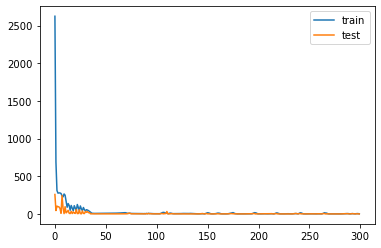

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

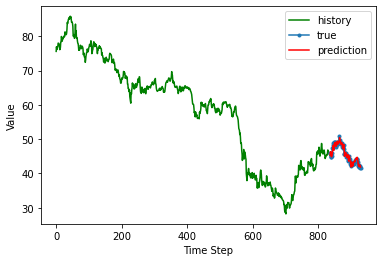

In [16]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

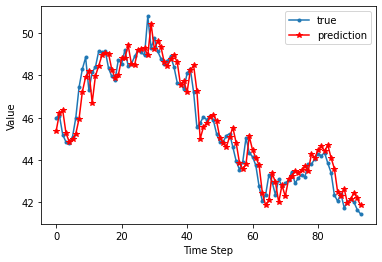

In [18]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [19]:
mean_absolute_percentage_error(y_test,y_pred)*100

1.1411901016295753

In [20]:
mean_squared_error(y_test,y_pred)

0.4465851326936861

In [21]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
[1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
Predicted direction accuracy (Up/down):
0.5268817204301075
